<a href="https://colab.research.google.com/github/Yashsharma009/fine-tune/blob/main/plastic-waste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Jul 25 12:33:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 607.6/607.6 kB 7.1 MB/s eta 0:00:00


In [3]:
from ultralytics import YOLO


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:

!yolo task=detect mode=train model=yolov8l.pt data=/content/drive/MyDrive/dataset-plastic1/data.yaml epochs=10 imgsz=640

100% 83.7M/83.7M [00:01<00:00, 57.7MB/s]
Ultralytics YOLOv8.0.141 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/drive/MyDrive/dataset-plastic1/data.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=to

In [7]:

import requests
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os


In [8]:

def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [9]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image


In [10]:
def count_plastics(labels):
    count = 0
    for label in labels:
        if label.lower() == 'plastic':
            count += 1
    return count


In [11]:
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    image_indices = random.sample(range(num_images), num_samples)  # Select random image indices

    for i, image_index in enumerate(image_indices):
        image_name = all_images[image_index]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[image_index])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0].strip()
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
        result_image = plot_box(image, bboxes, [])  # Pass an empty labels list
        count = len(bboxes)  # Count the number of bounding boxes as plastics
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
        plt.title(f'Plastics: {count}')  # Display box count as title
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()


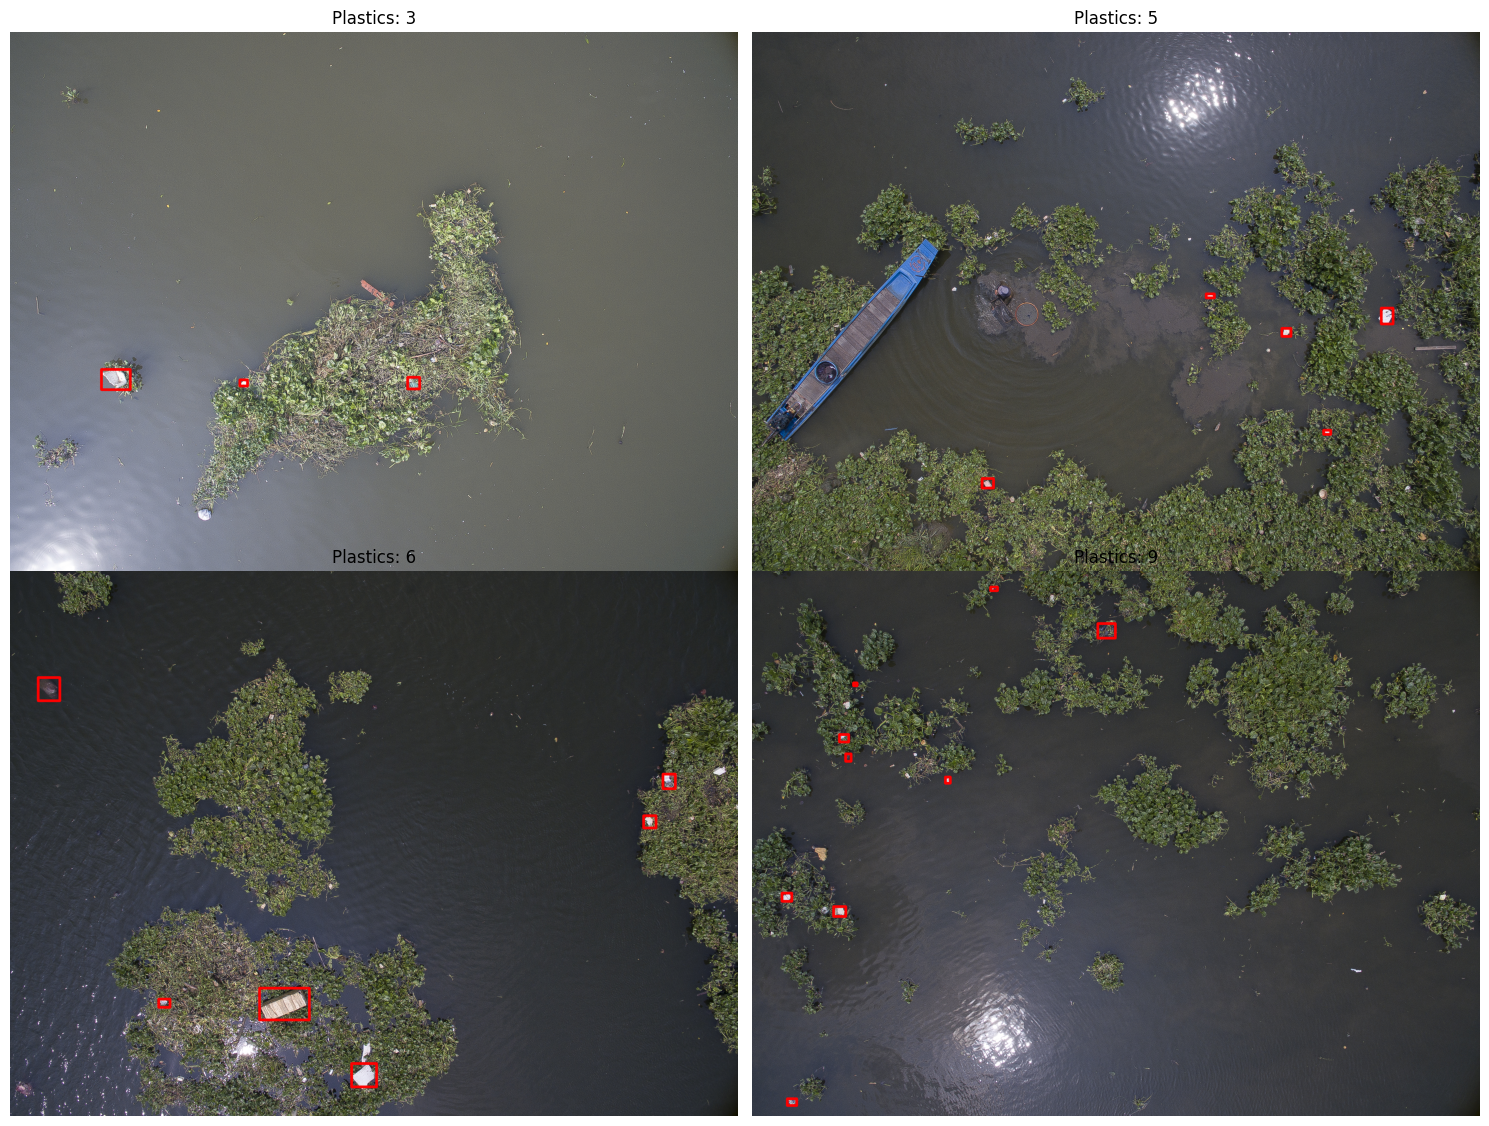

In [12]:
plot(
    image_paths='/content/drive/MyDrive/dataset-plastic1/train/images',
    label_paths='/content/drive/MyDrive/dataset-plastic1/train/labels',
    num_samples=4,
)

In [13]:
!yolo task=detect \
mode=predict \
model=/content/runs/detect/train/weights/best.pt \
source=/content/drive/MyDrive/dataset-plastic1/valid/images \
imgsz=640 \
name=yolov8n \
hide_labels=True

WARNING ⚠️ 'hide_labels' is deprecated and will be removed in 'ultralytics 8.2' in the future. Please use 'show_labels' instead.
Ultralytics YOLOv8.0.141 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43607379 parameters, 0 gradients

image 1/10 /content/drive/MyDrive/dataset-plastic1/valid/images/DJI_0023.jpg: 480x640 18 Plastics, 63.6ms
image 2/10 /content/drive/MyDrive/dataset-plastic1/valid/images/DJI_0080.jpg: 480x640 300 Plastics, 51.5ms
image 3/10 /content/drive/MyDrive/dataset-plastic1/valid/images/DJI_0088.jpg: 480x640 4 Plastics, 51.4ms
image 4/10 /content/drive/MyDrive/dataset-plastic1/valid/images/DJI_0185.jpg: 480x640 300 Plastics, 51.5ms
image 5/10 /content/drive/MyDrive/dataset-plastic1/valid/images/DJI_0205.jpg: 480x640 300 Plastics, 51.4ms
image 6/10 /content/drive/MyDrive/dataset-plastic1/valid/images/DJI_0255.jpg: 480x640 14 Plastics, 51.3ms
image 7/10 /content/drive/MyDrive/dataset-plastic1/valid/images/DJI_0268.jpg:

In [14]:
def visualize(result_dir, num_samples=4):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(20, 12))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
        if i == num_samples-1:
            break
    plt.tight_layout()
    plt.show()

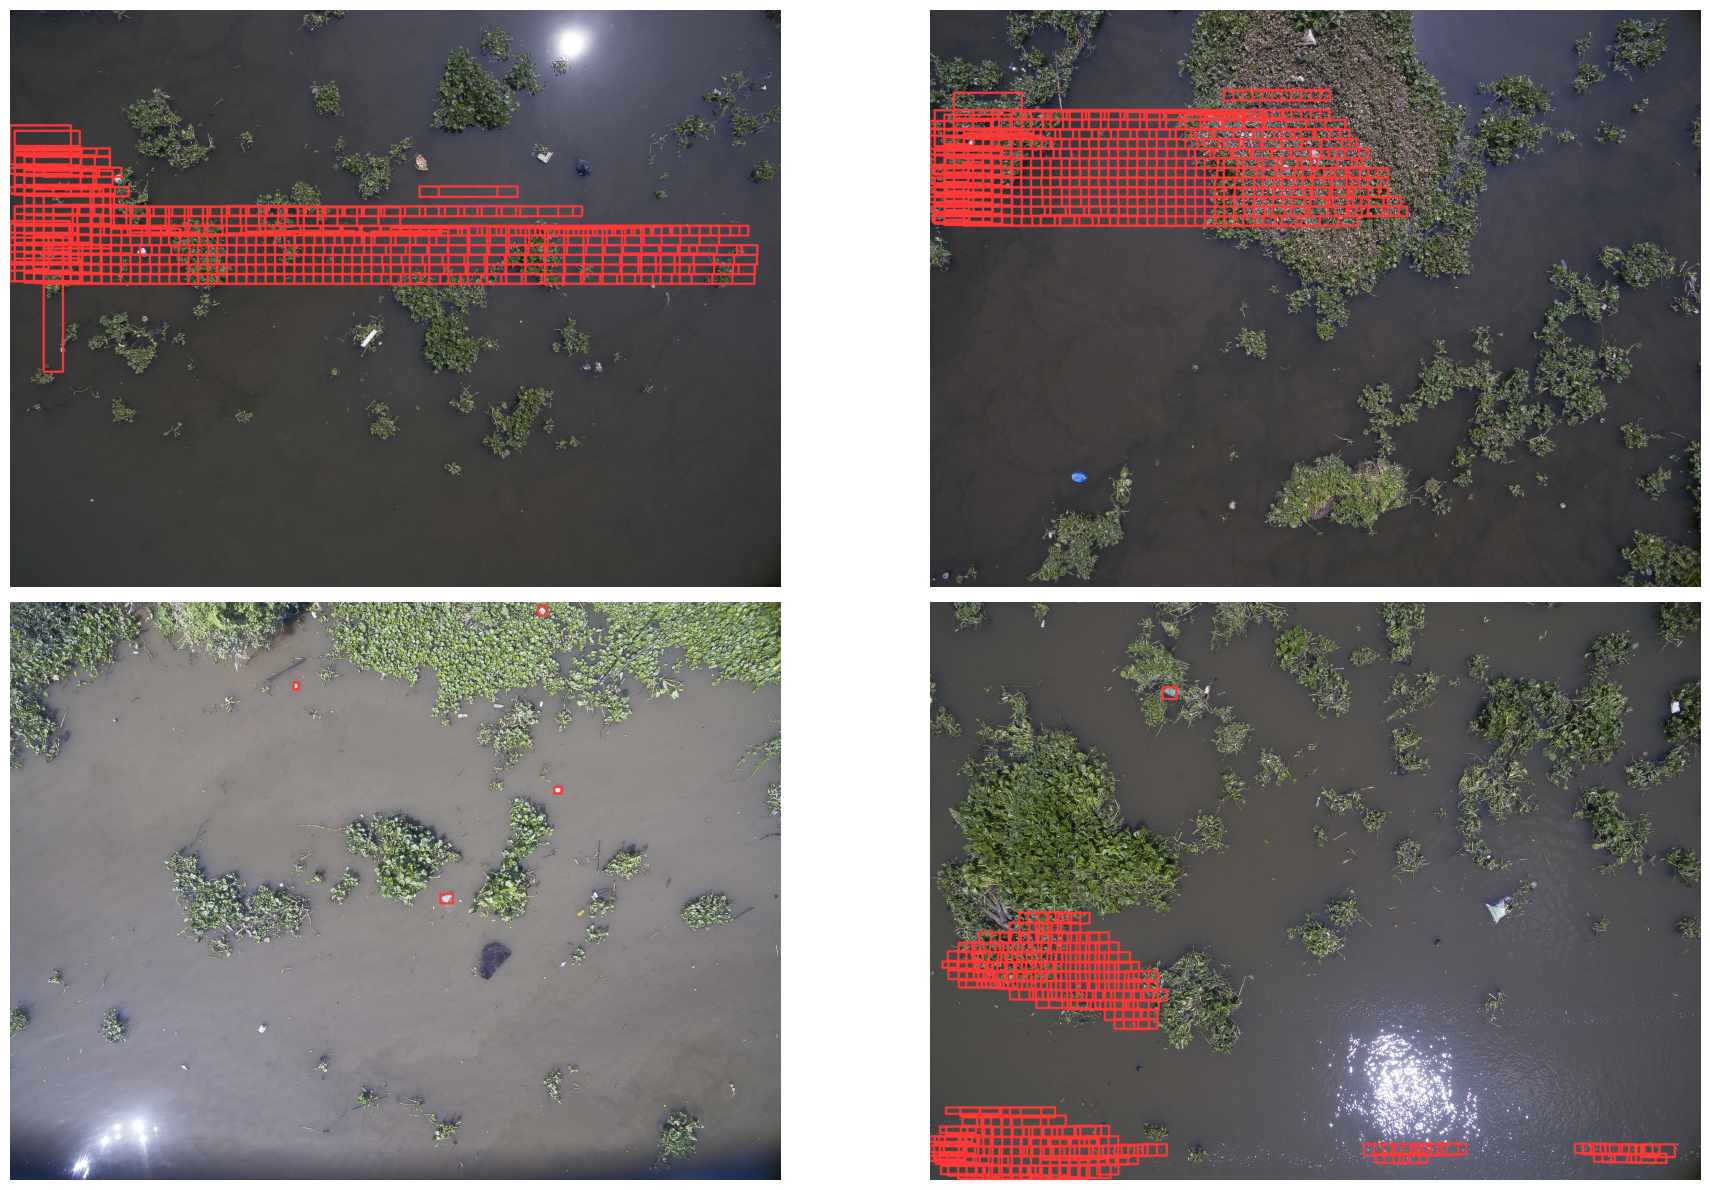

In [15]:
visualize('runs/detect/yolov8n')

In [18]:
import csv

# Replace 'path_to_csv_file.csv' with the actual path to your CSV file
geolocation_data = {}
with open('/content/drive/MyDrive/dataset-plastic1/Plastic detection code/output.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader)  # Skip the header row
    for row in csvreader:
        image_name = row[1]
        latitude = float(row[2]) if row[2] != '-' else None
        longitude = float(row[3]) if row[3] != '-' else None
        altitude = float(row[4]) if row[4] != '-' else None
        geolocation_data[image_name] = {'latitude': latitude, 'longitude': longitude, 'altitude': altitude}


In [20]:
def read_detection_results(detection_dir):
    detection_results = {}
    for filename in os.listdir(detection_dir):
        if filename.endswith('.txt'):
            image_name = filename[:-4]  # Remove the '.txt' extension
            with open(os.path.join(detection_dir, filename), 'r') as f:
                lines = f.readlines()
                detections = []
                for line in lines:
                    class_id, x_center, y_center, width, height, confidence = map(float, line.strip().split())
                    detections.append({'class_id': int(class_id), 'x_center': x_center, 'y_center': y_center,
                                       'width': width, 'height': height, 'confidence': confidence})
                detection_results[image_name] = detections
    return detection_results

# Replace 'runs/detect/yolov8n4' with the actual path to your YOLOv8 detection output directory
detection_results = read_detection_results('/content/runs/detect/yolov8n')


In [27]:
geolocated_plastics = []

for image_name, detections in detection_results.items():
    if image_name in geolocation_data:
        geolocation = geolocation_data[image_name]
        latitude = geolocation['latitude']
        longitude = geolocation['longitude']
        altitude = geolocation['altitude']
        # Check if geolocation data is available for the image
        if latitude is not None and longitude is not None and altitude is not None:
            for detection in detections:
                if detection['class_id'] == 0:  # Assuming class_id=0 corresponds to 'plastic'
                    x_center, y_center, width, height = detection['x_center'], detection['y_center'], detection['width'], detection['height']
                    # Convert the normalized coordinates to pixel coordinates (assuming your image size is 640x640)
                    x_pixel = int(x_center * 640)
                    y_pixel = int(y_center * 640)
                    # Now, you can convert the pixel coordinates to geolocation coordinates using some transformation or mapping function
                    # For example, you could use the latitude and longitude of the image as a reference point and calculate the offset
                    # from the image's center to the detected plastic.
                    # You may also need to consider the orientation of the drone when capturing the image to get more accurate geolocation.
                    # This step may vary depending on the exact mapping between pixel coordinates and geolocation in your specific use case.
                    geolocated_plastics.append({'latitude': latitude, 'longitude': longitude, 'altitude': altitude,
                                                'x_pixel': x_pixel, 'y_pixel': y_pixel})
        else:
            print(f"Warning: Missing geolocation data for image '{image_name}'. Skipping...")


In [26]:
import folium

# Replace 'center_latitude' and 'center_longitude' with the center latitude and longitude of your study area
center_latitude = 10.0
center_longitude = 100.0

# Create a folium map centered at the study area
m = folium.Map(location=[center_latitude, center_longitude], zoom_start=10)

for plastic in geolocated_plastics:
    latitude = plastic['latitude']
    longitude = plastic['longitude']
    x_pixel = plastic['x_pixel']
    y_pixel = plastic['y_pixel']

    # Convert the pixel coordinates to latitude and longitude using some transformation
    # Replace 'latitude_pixel_offset' and 'longitude_pixel_offset' with appropriate values based on your mapping
    latitude_pixel_offset = 0.0001
    longitude_pixel_offset = 0.0001

    latitude_offset = (x_pixel - 320) * latitude_pixel_offset
    longitude_offset = (y_pixel - 320) * longitude_pixel_offset

    # Calculate the final latitude and longitude of the detected plastic
    plastic_latitude = latitude + latitude_offset
    plastic_longitude = longitude + longitude_offset

    # Add a marker for the detected plastic on the folium map
    popup_content = f'Latitude: {plastic_latitude:.6f}, Longitude: {plastic_longitude:.6f}'
    folium.Marker(location=[plastic_latitude, plastic_longitude],
                  popup=popup_content).add_to(m)

# Display the folium map
m
